In [1]:
import geopandas as gpd
import json
import numpy as np
from pathlib import Path
from pyproj import CRS
import rasterio
import re
import shapely
from tqdm import tqdm

from tree_detection_framework.detection.region_detections import RegionDetections, reproject_detections
from tree_detection_framework.evaluation.evaluate import match_points, assess_matches

In [2]:
import tree_detection_framework
print(tree_detection_framework.__path__)

['/ofo-share/repos-eric/tree-detection-framework/tree_detection_framework']


# Overview

TODO: Explain

In [3]:
def gdf2rd(gdf):
    return RegionDetections(
        detection_geometries=None, data=gdf, CRS=gdf.crs
    )

In [4]:
PROJECT_ROOT = Path("/ofo-share/species-prediction-project/intermediate/")

# Hand pick these missions to check
CHECK = ["0004", "0005", "0009", "0014"]

# Load field survey data (ground truth)
gt_paths = [
    gpkg_path for gpkg_path in sorted((PROJECT_ROOT / "shifted_field_trees/").glob("*.gpkg"))
    if gpkg_path.name[:4] in CHECK
]
gt_pts = [gdf2rd(gpd.read_file(gpkg_path)) for gpkg_path in gt_paths]

# Load geometric tree detections, aligned with the field survey points
geo_paths = [
    PROJECT_ROOT / "detected_trees" / gpkg_path.stem / "tree_tops.gpkg"
    for gpkg_path in gt_paths
]
geo_pts = [gdf2rd(gpd.read_file(gpkg_path)) for gpkg_path in geo_paths]

# Find the canopy height models, aligned with the field survey points
chm_paths = [
    PROJECT_ROOT / "old_CHMs" / f"{gpkg_path.stem}.tif"
    for gpkg_path in gt_paths
]

# Find the digital surface models, aligned with the field survey points
dtm_paths = [
    PROJECT_ROOT / "photogrammetry" / gpkg_path.stem / "outputs" / f"{gpkg_path.stem}_dtm-ptcloud.tif"
    for gpkg_path in gt_paths
]

# Load orthomosaic tree detections, aligned with the field survey points
ortho_paths = [
    PROJECT_ROOT / "orthoML" / f"{gpkg_path.stem}-detectree2-predictions.gpkg"
    for gpkg_path in gt_paths
]
ortho_pts = [gdf2rd(gpd.read_file(gpkg_path)) for gpkg_path in ortho_paths]

# Load multi-view tree detections, aligned with the field survey points
mv_paths = [
    PROJECT_ROOT / "multiview" / gpkg_path.stem / "tree-locations" / "tree_locations.gpkg"
    for gpkg_path in gt_paths
]
mv_pts = [gdf2rd(gpd.read_file(gpkg_path)) for gpkg_path in mv_paths]

### CRS Values

What are we working with?

In [5]:
print(f"Field survey:\t{[rd.get_CRS().to_epsg() for rd in gt_pts]}")
print(f"Geo detections:\t{[str(rd.get_CRS()) for rd in geo_pts]}")
print(f"Ortho detections:\t{[str(rd.get_CRS()) for rd in ortho_pts]}")
print(f"Multiview detections:\t{[str(rd.get_CRS()) for rd in mv_pts]}")

chm_crs = []
for path in chm_paths:
    with rasterio.open(path) as src:
        chm_crs.append(str(src.crs))
dtm_crs = []
for path in dtm_paths:
    with rasterio.open(path) as src:
        dtm_crs.append(str(src.crs))
print(f"CHMs:\t\t{chm_crs}")
print(f"DTMs:\t\t{dtm_crs}")

Field survey:	[4326, 4326, 4326, 4326]
Geo detections:	['EPSG:26910', 'EPSG:26910', 'EPSG:26910', 'EPSG:26910']
Ortho detections:	['EPSG:26910', 'EPSG:26910', 'EPSG:26910', 'EPSG:26910']
Multiview detections:	['EPSG:4326', 'EPSG:4326', 'EPSG:4326', 'EPSG:4326']
CHMs:		['EPSG:26910', 'EPSG:26910', 'EPSG:26910', 'EPSG:26910']
DTMs:		['EPSG:26910', 'EPSG:26910', 'EPSG:26910', 'EPSG:26910']


In [6]:
assert len(set(dtm_crs)) == 1
assert all([chm == dtm_crs[0] for chm in chm_crs])

with rasterio.open(dtm_paths[0]) as src:
    matches = re.findall(r'AUTHORITY\["EPSG","(\d+)"\]', src.crs.to_wkt())
    target_crs = CRS.from_epsg(int(matches[-1]))

In [7]:
# Reconfigure the region detections
gt_pts = [
    reproject_detections(rd, target_crs)
    for rd in gt_pts
]

geo_pts = [
    reproject_detections(rd, target_crs)
    for rd in geo_pts
]

ortho_pts = [
    reproject_detections(rd, target_crs)
    for rd in ortho_pts
]

mv_pts = [
    reproject_detections(rd, target_crs)
    for rd in mv_pts
]

In [8]:
# Final check
print(f"Field survey:\t{[str(rd.get_CRS()) for rd in gt_pts]}")
print(f"Geo detections:\t{[str(rd.get_CRS()) for rd in geo_pts]}")
print(f"Ortho detections:\t{[str(rd.get_CRS()) for rd in ortho_pts]}")
print(f"Multiview detections:\t{[str(rd.get_CRS()) for rd in mv_pts]}")

Field survey:	['EPSG:26910', 'EPSG:26910', 'EPSG:26910', 'EPSG:26910']
Geo detections:	['EPSG:26910', 'EPSG:26910', 'EPSG:26910', 'EPSG:26910']
Ortho detections:	['EPSG:26910', 'EPSG:26910', 'EPSG:26910', 'EPSG:26910']
Multiview detections:	['EPSG:26910', 'EPSG:26910', 'EPSG:26910', 'EPSG:26910']


# Matching Points

2025-08-27 23:55:46,081 - INFO - Extracting treetop heights from CHM
2025-08-27 23:55:46,179 - INFO - Using height as an additional scaled dimension to compute distance


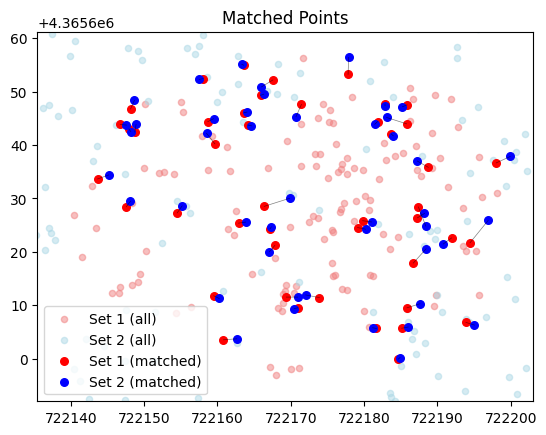

2025-08-27 23:55:46,537 - INFO - Extracting treetop heights from CHM
2025-08-27 23:55:46,574 - INFO - Using height as an additional scaled dimension to compute distance


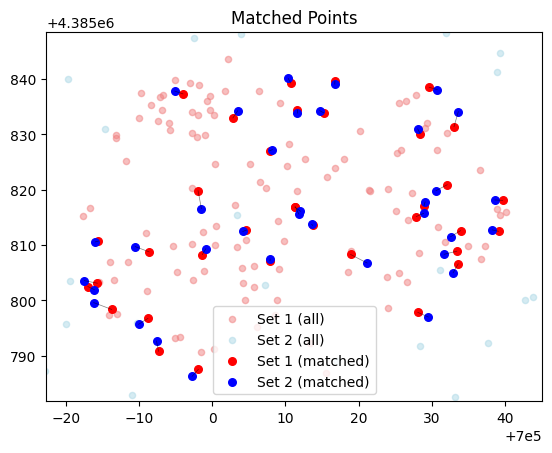

2025-08-27 23:55:46,800 - INFO - Extracting treetop heights from CHM
2025-08-27 23:55:46,838 - INFO - Using height as an additional scaled dimension to compute distance


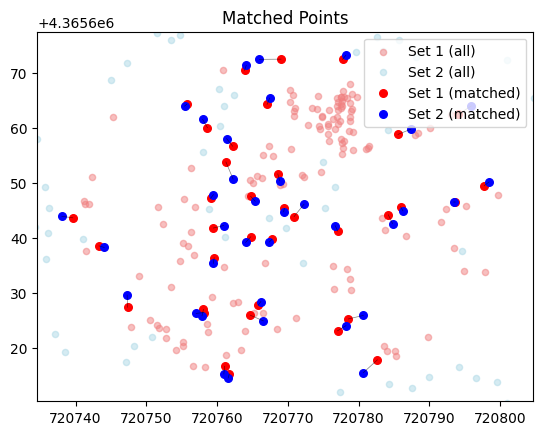

2025-08-27 23:55:47,065 - INFO - Extracting treetop heights from CHM
2025-08-27 23:55:47,094 - INFO - Using height as an additional scaled dimension to compute distance


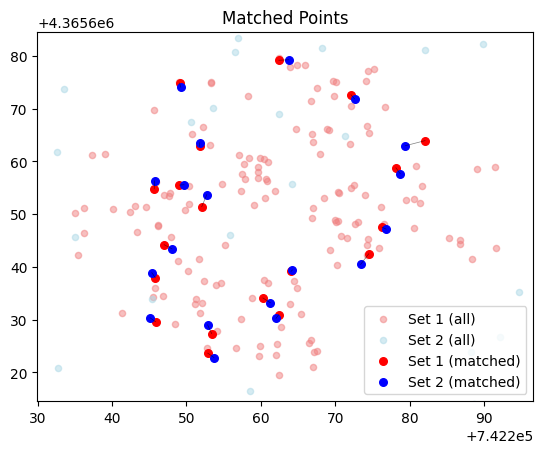

In [9]:
dataset1, hcol1 = gt_pts, {"height_column_1": "height"}
# dataset2, hcol2 = geo_pts, {"height_column_2": "height"}
dataset2, hcol2 = ortho_pts, {"fillin_method": "chm"}
# dataset2, hcol2 = mv_pts, {"fillin_method": "chm"}
name_stem = "GTvsORTHO"

matches = []
indices1 = []
indices2 = []
for pts1, pts2, chm_path in zip(dataset1, dataset2, chm_paths):
    matches.append(
        match_points(
            pts1,
            pts2,
            distance_threshold=lambda x: 0.1 * x + 2,
            use_height_in_distance=0.33,
            chm_path=chm_path,
            **hcol1,
            **hcol2,
            vis=True,
        )
    )
    # Do some bookkeeping to track which points are viable. At this point, all are
    indices1.append(set(pts1.detections.index.to_list()))
    indices2.append(set(pts2.detections.index.to_list()))

# Filter matches

Filter matches both to be above a certain height threshold, and also to be within certain geographic bounds.

### Heights

In [10]:
HEIGHT_CUTOFF_M = 5.0

In [11]:
new_matches = []
for i, (gpkg_path, match_set, cpath, ds1, ds2) in enumerate(zip(gt_paths, matches, chm_paths, dataset1, dataset2)):
    coords1 = shapely.get_coordinates(ds1.get_data_frame().geometry)
    coords2 = shapely.get_coordinates(ds2.get_data_frame().geometry)
    with rasterio.open(cpath) as chm:
        chm1 = np.array(list(chm.sample(coords1)))
        chm2 = np.array(list(chm.sample(coords2)))

    if "height_column_1" not in hcol1:
        height1 = chm1
    else:
        height1 = np.array(ds1.detections["height"]).reshape(-1, 1)
    if "height_column_2" not in hcol2:
        height2 = chm2
    else:
        height2 = np.array(ds2.detections["height"]).reshape(-1, 1)
    
    new_match_set = []
    for idx1, idx2, dist in match_set:
        if height1[idx1] >= HEIGHT_CUTOFF_M and height2[idx2] >= HEIGHT_CUTOFF_M:
            new_match_set.append((idx1, idx2, dist))
    new_matches.append(new_match_set)
    print(f"{len(match_set)} matches → {len(new_match_set)} matches")

    # Bookkeep the indices
    for indices, height in ((indices1[i], height1), (indices2[i], height2)):
        bad = []
        for idx in indices:
            if height[idx] < HEIGHT_CUTOFF_M:
                bad.append(idx)
        print(f"\tRemoving {len(bad)} / {len(indices)} possible indices")
        for idx in bad:
            indices.remove(idx)

45 matches → 41 matches
	Removing 61 / 166 possible indices
	Removing 604 / 1809 possible indices
35 matches → 34 matches
	Removing 46 / 146 possible indices
	Removing 269 / 829 possible indices
36 matches → 36 matches
	Removing 69 / 174 possible indices
	Removing 254 / 803 possible indices
19 matches → 19 matches
	Removing 0 / 163 possible indices
	Removing 128 / 476 possible indices


In [12]:
matches = new_matches

### Boundaries

In [13]:
boundaries = gpd.read_file("/ofo-share/species-prediction-project/raw/ground-reference/ofo_ground-reference_plots.gpkg")
boundaries = boundaries.to_crs(gt_pts[0].get_CRS())

In [14]:
new_matches = []
for i, (gpkg_path, match_set, ds1, ds2) in enumerate(zip(gt_paths, matches, dataset1, dataset2)):
    new_match_set = []
    boundary = boundaries.loc[boundaries["plot_id"] == gpkg_path.stem[:4], "geometry"].iloc[0]
    for idx1, idx2, dist in match_set:
        pt1 = ds1.detections.loc[idx1, "geometry"]
        pt2 = ds2.detections.loc[idx2, "geometry"]
        if pt1.within(boundary) and pt2.within(boundary):
            new_match_set.append((idx1, idx2, dist))
    new_matches.append(new_match_set)
    print(f"{len(match_set)} matches → {len(new_match_set)} matches")

    # Bookkeep the indices
    for indices, dataset in ((indices1[i], ds1), (indices2[i], ds2)):
        bad = []
        for idx in indices:
            pt = dataset.detections.loc[idx, "geometry"]
            if not pt.within(boundary):
                bad.append(idx)
        print(f"\tRemoving {len(bad)} / {len(indices)} possible indices")
        for idx in bad:
            indices.remove(idx)

41 matches → 39 matches
	Removing 3 / 105 possible indices
	Removing 1147 / 1205 possible indices
34 matches → 31 matches
	Removing 3 / 100 possible indices
	Removing 524 / 560 possible indices
36 matches → 33 matches
	Removing 3 / 105 possible indices
	Removing 511 / 549 possible indices
19 matches → 17 matches
	Removing 9 / 163 possible indices
	Removing 331 / 348 possible indices


In [15]:
matches = new_matches

# Output cylinder info

In [16]:
data = {}
for path, tpath, cpath, rd1, rd2, idxset1, idxset2, match_data in zip(tqdm(gt_paths), dtm_paths, chm_paths, dataset1, dataset2, indices1, indices2, matches):
    coords1 = shapely.get_coordinates(rd1.get_data_frame().geometry)
    coords2 = shapely.get_coordinates(rd2.get_data_frame().geometry)
    with rasterio.open(tpath) as dtm:
        dtm1 = np.array(list(dtm.sample(coords1)))
        dtm2 = np.array(list(dtm.sample(coords2)))
    with rasterio.open(cpath) as chm:
        chm1 = np.array(list(chm.sample(coords1)))
        chm2 = np.array(list(chm.sample(coords2)))

    if "height_column_1" not in hcol1:
        height1 = chm1
    else:
        height1 = np.array(rd1.detections["height"]).reshape(-1, 1)
    if "height_column_2" not in hcol2:
        height2 = chm2
    else:
        height2 = np.array(rd2.detections["height"]).reshape(-1, 1)
    
    idx1 = [i1 for i1, _, _ in match_data]
    idx2 = [i2 for _, i2, _ in match_data]
    mask1 = np.zeros(len(coords1), dtype=bool)
    mask2 = np.zeros(len(coords2), dtype=bool)
    mask1[idx1] = True
    mask2[idx2] = True

    precision, recall, f1_score = assess_matches(match_data, len(idxset1), len(idxset2))

    data[path.stem] = {
        "precision": precision,
        "recall": recall,
        "f1_score": f1_score,
        "matched": {
            "pts1": {
                "starts": np.hstack([coords1[idx1], dtm1[idx1]]).tolist(),
                "ends": np.hstack([coords1[idx1], dtm1[idx1] + height1[idx1]]).tolist(),
            },
            "pts2": {
                "starts": np.hstack([coords2[idx2], dtm2[idx2]]).tolist(),
                "ends": np.hstack([coords2[idx2], dtm2[idx2] + height2[idx2]]).tolist(),
            },
            "between": {
                "starts": np.hstack([coords1[idx1], dtm1[idx1] + height1[idx1]]).tolist(),
                "ends": np.hstack([coords2[idx2], dtm2[idx2] + height2[idx2]]).tolist(),
            }
        },
        "unmatched": {
            "pts1": {
                "starts": np.hstack([coords1[~mask1], dtm1[~mask1]]).tolist(),
                "ends": np.hstack([coords1[~mask1], dtm1[~mask1] + height1[~mask1]]).tolist(),
            },
            "pts2": {
                "starts": np.hstack([coords2[~mask2], dtm2[~mask2]]).tolist(),
                "ends": np.hstack([coords2[~mask2], dtm2[~mask2] + height2[~mask2]]).tolist(),
            },
        },
    }

100%|██████████| 4/4 [00:01<00:00,  2.85it/s]


In [17]:
SAVE = Path("/ofo-share/scratch-eric/evaluate_matches/")
json.dump(data, (SAVE / f"{name_stem}.json").open("w"))